## **Import dependencies**

In [3]:
! pip install WordCloud --q

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importing WordCloud for text visualization
from wordcloud import WordCloud

# Importing NLTK for natural language processing
import nltk
from nltk.corpus import stopwords    # For stopwords


# Downloading NLTK data
nltk.download('stopwords')   # Downloading stopwords data
nltk.download('punkt')       # Downloading tokenizer data

[nltk_data] Downloading package stopwords to C:\Users\Santosh
[nltk_data]     Kumar_TSI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to C:\Users\Santosh
[nltk_data]     Kumar_TSI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

## **Load the dataset:**

In [7]:
df= pd.read_csv("C:/Users/Santosh Kumar_TSI/MLOPS-Complete-ML-Pipeline/experiment/spam.csv")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## **Remove the columns which are not required**

In [11]:
df=df[["v2","v1"]].rename(columns= {"v2":"text","v1":"target"})

## **Know your data**

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   target  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [27]:
df.isna().sum()

text      0
target    0
dtype: int64

In [15]:
df.duplicated().sum()

403

In [18]:
df.drop_duplicates(keep="first",inplace=True)

In [20]:
df.duplicated().sum()

0

In [30]:
df.target.describe()

count     5169
unique       2
top        ham
freq      4516
Name: target, dtype: object

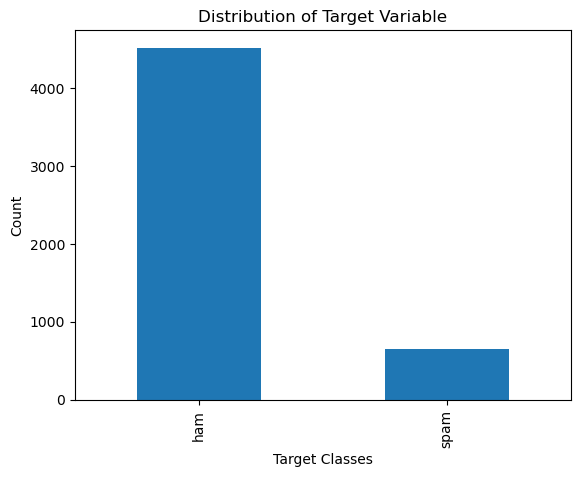

In [33]:
df.target.value_counts().plot(kind='bar')
plt.xlabel("Target Classes")
plt.ylabel("Count")
plt.title("Distribution of Target Variable")
plt.show()

### **observation:**
- Data is highly